<a href="https://colab.research.google.com/github/verneh/pytorch/blob/main/effnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing efficientnet for CNN of X-rays \
Reference - https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Computer_Vision/42-EfficientNet_Pretrained_Pytorch_Covid_19_X_Rays.ipynb

In [1]:
# Install libraries
!pip install timm

     |████████████████████████████████| 431 kB 5.4 MB/s 


In [2]:
!nvidia-smi

Mon Mar 28 16:17:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import libraries
import copy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from tqdm import tqdm

import time
import timm

import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


Download dataset [here](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset) and stage it in /content.

In [11]:
!unzip -q "/content/dataset.zip"

In [12]:
ROOT_PATH = "/content/Covid19-dataset/"

In [13]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Move images

In [14]:
train_dir = os.path.join(ROOT_PATH, 'train')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

train_covid_fnames = os.listdir(train_covid_dir)
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

print(train_covid_fnames[:10])
print(train_normal_fnames[:10])
print(train_pneumonia_fnames[:10])

['068.jpg', 'COVID-00003a.jpg', 'COVID-00005.jpg', '039.jpeg', 'COVID-00021.jpg', 'COVID-00012.jpg', '025.jpeg', 'COVID-00008.jpg', '019.png', '033.png']
['05.jpeg', '025.jpeg', '09.jpeg', '068.jpeg', '023.jpeg', '086.jpeg', '062.jpeg', '058.jpeg', '071.jpeg', '075.jpeg']
['05.jpeg', '025.jpeg', '09.jpeg', '068.jpeg', '046.jpeg', '036.jpeg', '023.jpeg', '062.jpeg', '058.jpeg', '047.jpeg']


covid_img_path_list ['/content/Covid19-dataset/train/Covid/068.jpg', '/content/Covid19-dataset/train/Covid/COVID-00003a.jpg', '/content/Covid19-dataset/train/Covid/COVID-00005.jpg', '/content/Covid19-dataset/train/Covid/039.jpeg', '/content/Covid19-dataset/train/Covid/COVID-00021.jpg', '/content/Covid19-dataset/train/Covid/COVID-00012.jpg', '/content/Covid19-dataset/train/Covid/025.jpeg', '/content/Covid19-dataset/train/Covid/COVID-00008.jpg']


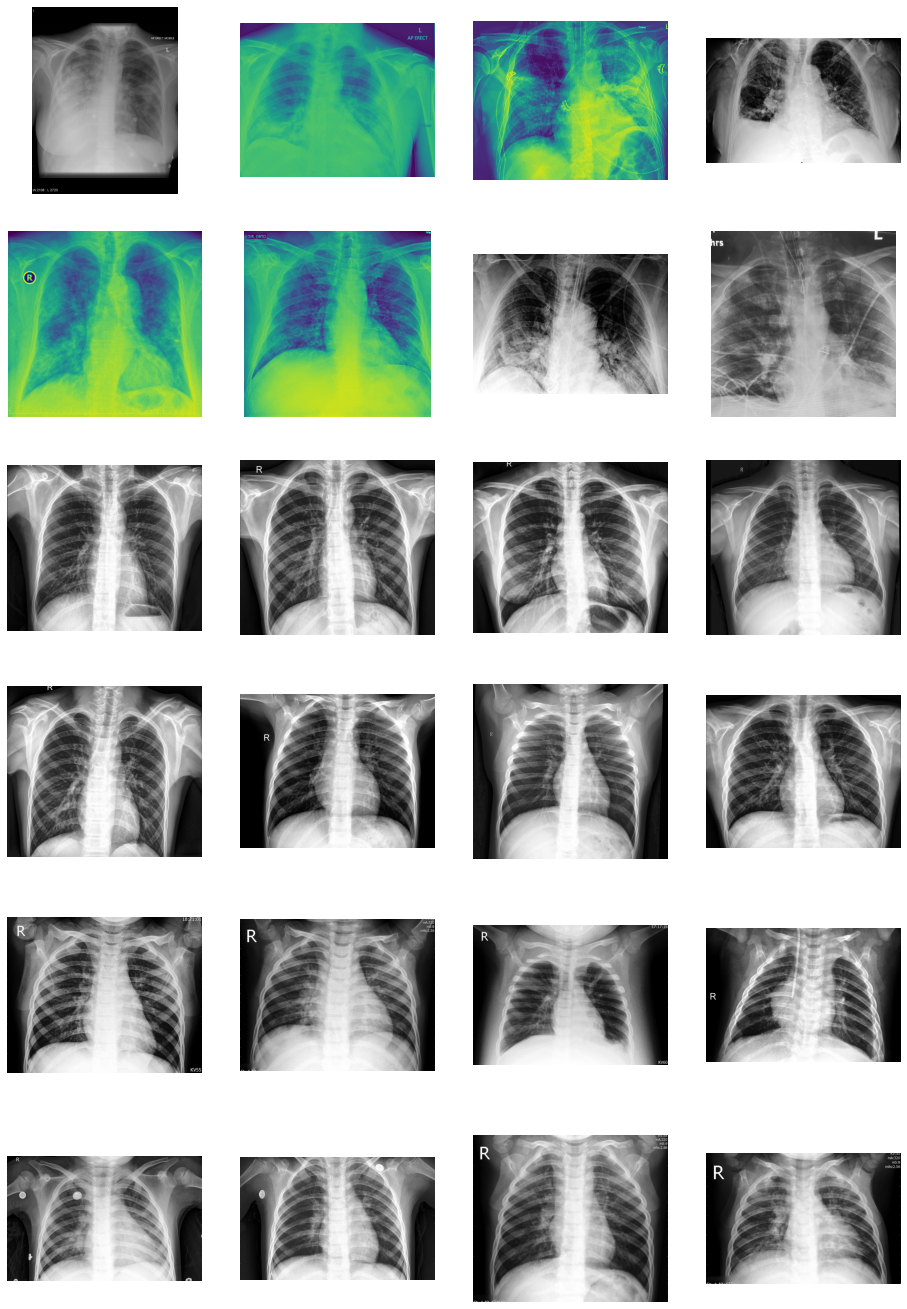

In [15]:
# we print a rows of images.
nrows = 6
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

covid_img_path_list = [os.path.join(train_covid_dir, fname) 
                for fname in train_covid_fnames[ pic_index-8:pic_index] ]
print("covid_img_path_list", covid_img_path_list)


normal_img_list = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

pneumonia_img_list = [os.path.join(train_pneumonia_dir, fname) 
                for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(covid_img_path_list+normal_img_list+pneumonia_img_list):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Now we see the difference in the sizes of the images. We need to augment this.

In [16]:
def get_dataset_loader(data_path, batch_size=256, train=False):
  if train:
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), transforms.GaussianBlur(3)]), p=0.1),
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
      transforms.RandomErasing(p=0.12, value='random')
    ])

    train_imgs = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'), transform=transform)

    print(f"We have {len(train_imgs)} Training Images with {len(train_imgs.classes)} classes")

    len_train_images = int(len(train_imgs) * 0.78)
    
    len_validation_images = int(len(train_imgs) - len_train_images )

    train_dataset, validation_dataset = random_split(train_imgs, [len_train_images, len_validation_images] )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_dataloader, validation_dataloader, len(train_dataset), len(validation_dataset)

  else:
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
  ])
  
  test_imgs = datasets.ImageFolder(os.path.join(ROOT_PATH, 'test/'), transform=transform)
  
  print(f"We have {len(test_imgs)} Training Images with {len(test_imgs.classes)} classes")
  
  test_dataloader = DataLoader(test_imgs, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  
  return test_dataloader, len(test_imgs)

In [17]:
class_categories = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/')).classes
# ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(class_categories)
num_classes

3

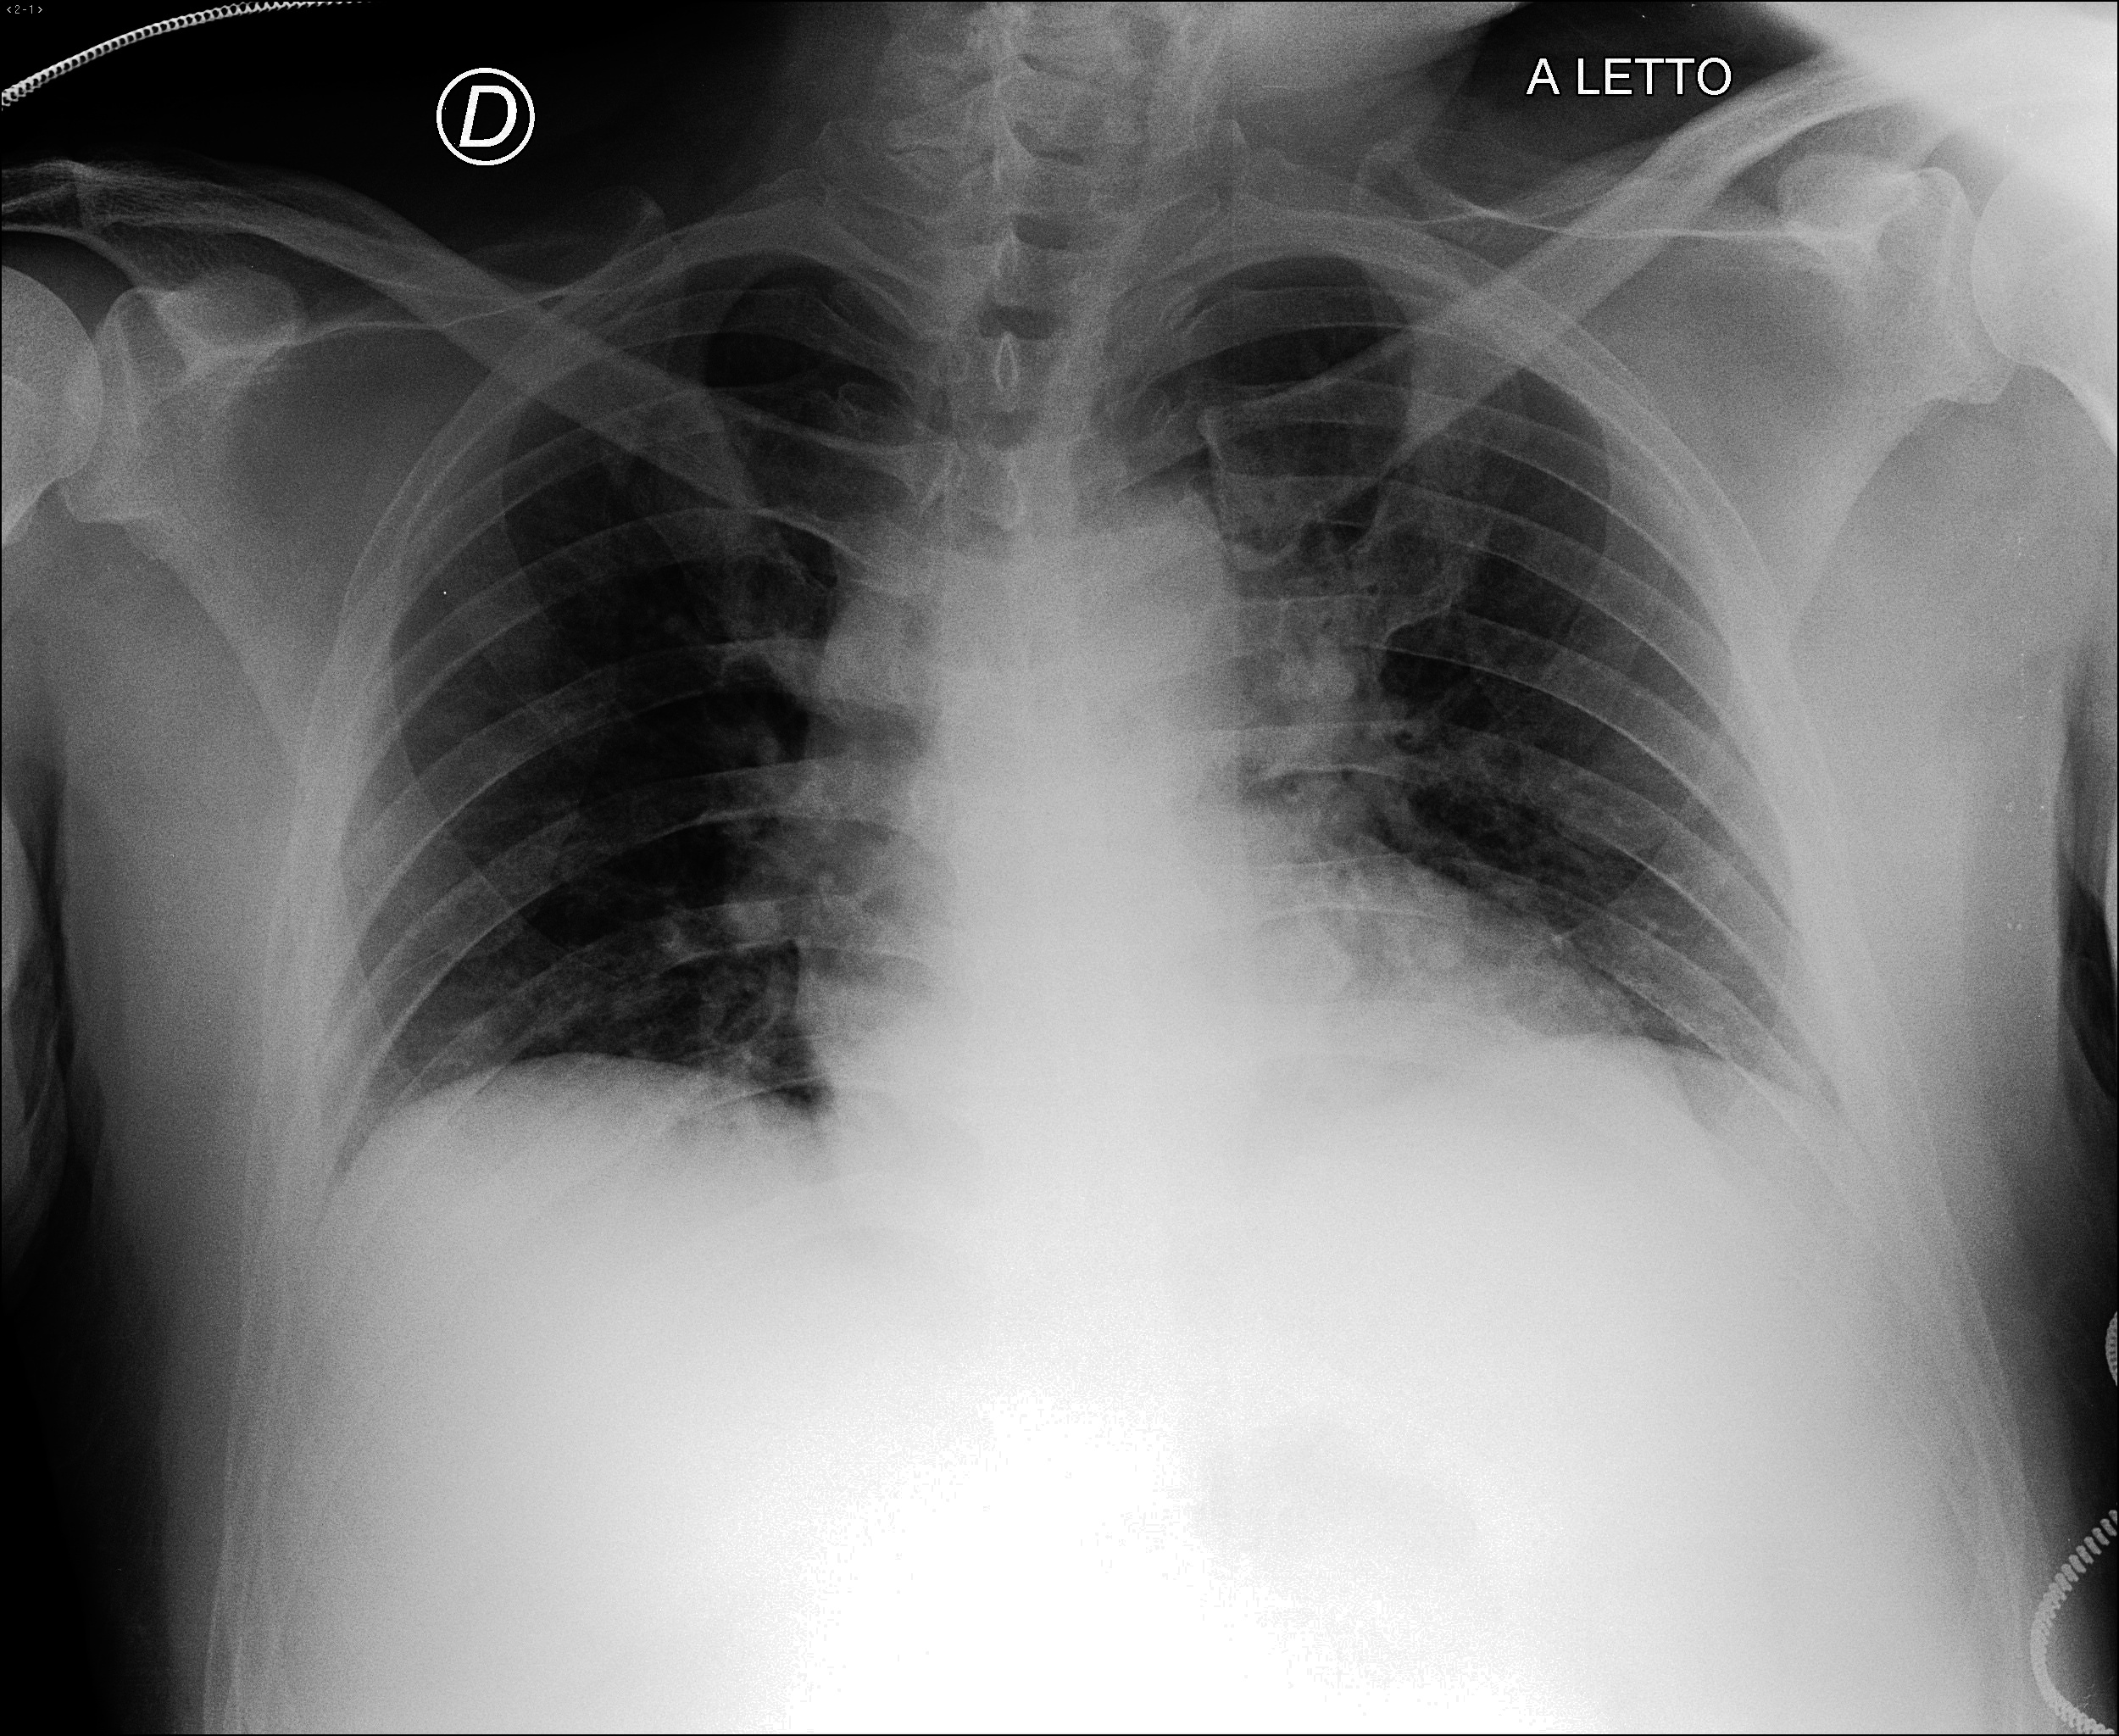

In [18]:
# Display images
train_data = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'))
train_data[2][0]

In [19]:
# Grab all the loaders

BATCH_SIZE = 32

(train_dataloader, validation_dataloader, len_train_dataloader, len_validation_dataloader) = get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=True)

(test_dataloader, len_test_dataloader) = get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=False)

We have 251 Training Images with 3 classes
We have 66 Training Images with 3 classes


In [20]:
dataloaders_dict = {
  'train': train_dataloader,
  'validation': validation_dataloader
}

dataset_sizes_dict = {
  'train':len_train_dataloader,
  'validation': len_validation_dataloader
}

In [21]:
for i, (inputs, labels) in enumerate(train_dataloader):
    print(inputs.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 3, 224, 224]) torch.Size([3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels list is  tensor([0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 2, 0, 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

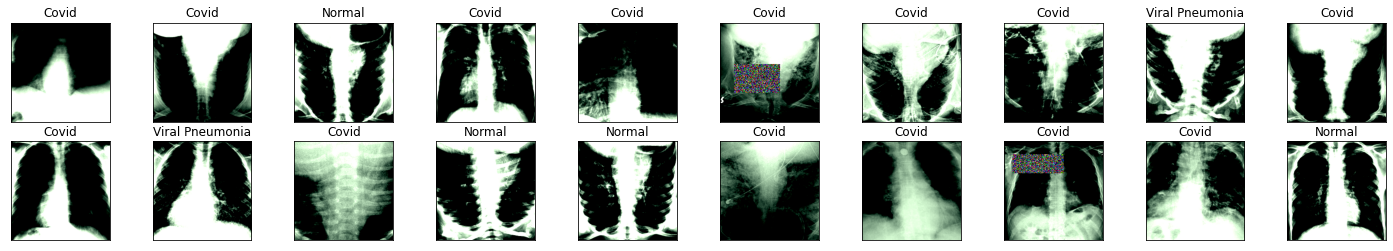

In [22]:
train_loader_iterable = iter(train_dataloader)

images, labels = train_loader_iterable.next()

print('labels list is ', labels)

# Now for displaying I have to convert images to Numpy
images = images.numpy()
# plt.imshow(images[1][1]) # this is will display this image

# Plot images in batch along with corresponding labels.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[] )
  plt.imshow(np.transpose(images[idx], (1,2,0)))
  # in above line transpose should convert
  # a `[channel, height, width]` tensor to a `[height, width, channel]` one.
  
  ax.set_title(class_categories[labels[idx]])

# Load EfficientNet

In [23]:
torch.backends.cudnn.benchmark = True

model = models.efficientnet_b0(pretrained=True)

print("model.classifier is => ", model.classifier)

""" model.classifier is =>  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
"""

for param in model.parameters():
  param.requires_grad = False
  
num_inputs = model.classifier[1].in_features


""" Now here is where I am adding additional layers to the pre-trained model.

for nn.Linear - note the following
in_features – size of each input sample
out_features – size of each output sample

"""


model.classifier = nn.Sequential(
  nn.Linear(num_inputs, 2048),
  nn.SiLU(), # Sigmoid Weighted Linear Unit
  nn.Dropout(0.2),
  # Note that the last layer is 2048 * Number of Classes
  # Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
  nn.Linear(2048, len(class_categories))
)

model = model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

model.classifier is =>  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=3, bias=True)
)


In [24]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001 )

Formula of Label Smoothing
Label smoothing replaces one-hot encoded label vector y_hot with a mixture of y_hot and the uniform distribution:

y_ls = (1 - α) * y_hot + α / K

In [25]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [26]:
training_history = {'accuracy': [], 'loss':[] }
validation_history = {'accuracy': [], 'loss': []}

In [27]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
  start_time = time.time()
  
  best_model_weights = copy.deepcopy(model.state_dict())
  best_accuracy = 0.0
  
  for epoch in range(num_epochs):
    print('Running epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    """ Within each epoch first configure training or eval mode 
    based on wheather I am in the 'train' or 'validation' phase.
    
    `model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc.
     which behave different on the train and test procedures know what is going on and hence can behave accordingly.
    
    In below, after I start the for loop for phase, the rest entire code for this train() function runs
    within this for loop and at various stage passing the phase variable to be either 'train' or 
    'validation'
    
    """
    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0
      
      """ now start the iteration of the dataloaders_dict variable
      i.e. for both 'train' and 'validation' phases 
      
      Below loop, basically tells that, for every epoch the train_dataloader and then the validation_dataloader is invoked
       which returns input and its corresponding label. 
      
      """
      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        """ for every mini-batch during the training phase, we typically want to explicitly set the gradients 
        to zero before starting to do backpropragation """
        optimizer.zero_grad()
        
        """ Start the forward movement
        tracking history for phase == 'train' 
        set_grad_enabled is a Context-manager that sets gradient calculation to on or off.

        The argument to it is called mode (which is a boolean ), and this mode controls whether to enable grad (True), 
        or disable (False). This can be used to conditionally enable gradients.
        """
        with torch.set_grad_enabled(phase == 'train'):
          predicted_outputs = model(inputs)          
          # print('outputs on which to apply torch.max ', outputs)
          # find the maximum along the rows, use dim=1 to torch.max()
          _, predictions = torch.max(predicted_outputs, 1)
          
          loss = criterion(predicted_outputs, labels)
          
          # Now for the 'train' phase, do backpropagation and update weights with step()
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        """ Update the running loss and corrects 
        we need to use, loss.item() instead of loss alone in running_loss calculation and averaging. 
        Because loss gives you a grad_function, not a float value. 
        The item() method extracts the loss’s value as a Python float.
        """
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        
      if phase == 'train':
        scheduler.step()      
      
      epoch_loss = running_loss / dataset_sizes_dict[phase]
      epoch_accuracy = running_corrects.double() / dataset_sizes_dict[phase]
      
      """ To summarize, in the above code what I did is
      
      1. => multiply each average batch loss with batch-length. 
      The batch-length is inputs.size(0) which gives the number total images in each batch. 
      Essentially I am un-averaging the Batch-Loss

      Do this all the batches inside the batch-running loop.
      And then after that loop, i.e. outside the batch-loop and coming back to my epoch-loop
      
      2. => Divide this accumulated un-averaged Batch-loss from all batches, 
      by the number of samples (len(train_dataloader)) to get the exact train loss average for the epoch """
      
      
      if phase == 'train':
        training_history['loss'].append(epoch_loss)
        training_history['accuracy'].append(epoch_accuracy)
      elif phase == 'validation':
        validation_history['loss'].append(epoch_loss)
        validation_history['accuracy'].append(epoch_accuracy)
        
      # finally update best_accuracy and deep copy the model
      if phase == 'validation' and epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())
  
  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60
  ))
  print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
  
  # loading best model weights
  model.load_state_dict(best_model_weights)
  return model

In [28]:
model_trained = train(model, criterion, optimizer, exp_lr_scheduler, num_epochs=150)

Running epoch 0/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


Running epoch 1/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Running epoch 2/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Running epoch 3/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Running epoch 4/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


Running epoch 5/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Running epoch 6/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Running epoch 7/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Running epoch 8/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.84s/it]


Running epoch 9/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Running epoch 10/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


Running epoch 11/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Running epoch 12/149
----------


100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


Running epoch 13/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Running epoch 14/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Running epoch 15/149
----------


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Running epoch 16/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Running epoch 17/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Running epoch 18/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


Running epoch 19/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.66s/it]


Running epoch 20/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


Running epoch 21/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Running epoch 22/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Running epoch 23/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


Running epoch 24/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Running epoch 25/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Running epoch 26/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


Running epoch 27/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Running epoch 28/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Running epoch 29/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Running epoch 30/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


Running epoch 31/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Running epoch 32/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.65s/it]


Running epoch 33/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Running epoch 34/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Running epoch 35/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


Running epoch 36/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Running epoch 37/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Running epoch 38/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Running epoch 39/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


Running epoch 40/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Running epoch 41/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Running epoch 42/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


Running epoch 43/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


Running epoch 44/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Running epoch 45/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Running epoch 46/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


Running epoch 47/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Running epoch 48/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Running epoch 49/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Running epoch 50/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Running epoch 51/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Running epoch 52/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Running epoch 53/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Running epoch 54/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Running epoch 55/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Running epoch 56/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.88s/it]


Running epoch 57/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Running epoch 58/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Running epoch 59/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


Running epoch 60/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Running epoch 61/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Running epoch 62/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.47s/it]


Running epoch 63/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Running epoch 64/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Running epoch 65/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Running epoch 66/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.83s/it]


Running epoch 67/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.98s/it]


Running epoch 68/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Running epoch 69/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Running epoch 70/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Running epoch 71/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


Running epoch 72/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Running epoch 73/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Running epoch 74/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Running epoch 75/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Running epoch 76/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.47s/it]


Running epoch 77/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


Running epoch 78/149
----------


100%|██████████| 2/2 [00:05<00:00,  3.00s/it]


Running epoch 79/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


Running epoch 80/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Running epoch 81/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


Running epoch 82/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


Running epoch 83/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


Running epoch 84/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


Running epoch 85/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


Running epoch 86/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Running epoch 87/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


Running epoch 88/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Running epoch 89/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.80s/it]


Running epoch 90/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Running epoch 91/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.88s/it]


Running epoch 92/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


Running epoch 93/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Running epoch 94/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


Running epoch 95/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Running epoch 96/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Running epoch 97/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


Running epoch 98/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


Running epoch 99/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Running epoch 100/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


Running epoch 101/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


Running epoch 102/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Running epoch 103/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


Running epoch 104/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Running epoch 105/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


Running epoch 106/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Running epoch 107/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Running epoch 108/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.61s/it]


Running epoch 109/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Running epoch 110/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Running epoch 111/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


Running epoch 112/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Running epoch 113/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Running epoch 114/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Running epoch 115/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Running epoch 116/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.05s/it]


Running epoch 117/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Running epoch 118/149
----------


100%|██████████| 2/2 [00:07<00:00,  3.65s/it]


Running epoch 119/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Running epoch 120/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Running epoch 121/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


Running epoch 122/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


Running epoch 123/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


Running epoch 124/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Running epoch 125/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


Running epoch 126/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.03s/it]


Running epoch 127/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Running epoch 128/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Running epoch 129/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Running epoch 130/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Running epoch 131/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Running epoch 132/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Running epoch 133/149
----------


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Running epoch 134/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.69s/it]


Running epoch 135/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Running epoch 136/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Running epoch 137/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


Running epoch 138/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


Running epoch 139/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Running epoch 140/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Running epoch 141/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


Running epoch 142/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


Running epoch 143/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Running epoch 144/149
----------


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


Running epoch 145/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Running epoch 146/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Running epoch 147/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Running epoch 148/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Running epoch 149/149
----------


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

Training complete in 49m 59s
Best Validation Accuracy: 0.964286


In [29]:
def evaluate(model):
  loss_on_test_dataset = 0.0
  correct_class = list(0. for i in range(len(class_categories)))
  total_correct_for_all_classes = list(0. for i in range(len(class_categories)))
  
  model.eval()
  
  for test_inputs, test_labels in tqdm(test_dataloader):
    # In local machine, below 2 Lines will NOT work if local GPU
    # itself or the GPU's Compute Capability is NOT compatible with PyTorch
    if torch.cuda.is_available():
      test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()
    
    with torch.no_grad():
      output_test = model(test_inputs)
      loss = criterion(output_test, test_labels)
    
    loss_on_test_dataset += loss.item() * test_inputs.size(0)
    _, pred_test = torch.max(output_test, 1)
    
    """ 
    Now compare predictions to true label
    
    view_as => View this tensor as the same size as other. 
    self.view_as(other) is equivalent to self.view(other.size()).   
    tensor.view_as(other) is equivalent to tensor.view(other.size())
    """
    correct_tensor = pred_test.eq(test_labels.view_as(pred_test))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # Basically above will make sure if gpu is not available then we copy the tensor to cpu and convert it to numpy array.
    
    if len(test_labels) == BATCH_SIZE:
      for i in range(BATCH_SIZE):
        label = test_labels.data[i]
        correct_class[label] += correct[i].item() # updating corrects for each class object
        total_correct_for_all_classes[label] += 1 # updating corrects for total classes
        
  loss_on_test_dataset = loss_on_test_dataset/len(test_dataloader.dataset)
  print('Test Loss: {:.6f}\n'.format(loss_on_test_dataset))
  
  for i in range(len(class_categories)):
    if total_correct_for_all_classes[i] > 0:
      # Now print total Accuracy % and also number of corrects vs total number
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        class_categories[i], 100 * correct_class[i] / total_correct_for_all_classes[i],
        np.sum(correct_class[i]), np.sum(total_correct_for_all_classes[i])
      ))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (class_categories[i]))
  
  print('\n Test Accuracy (Overall): {:.4f} ({}/{})'.format(
    100 * np.sum(correct_class) / np.sum(total_correct_for_all_classes),
    np.sum(correct_class), np.sum(total_correct_for_all_classes)
  ))
    

In [30]:
evaluate(model_trained)

100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Test Loss: 0.464203

Test Accuracy of Covid: 100% (24/24)
Test Accuracy of Normal: 90% (18/20)
Test Accuracy of Viral Pneumonia: 95% (19/20)

 Test Accuracy (Overall): 95.3125 (61.0/64.0)


In [49]:
torch.save(model_trained.state_dict(), 'model_weights.pth')